# Análisis de Frecuencia de Clientes Wi-Fi

Este notebook permite identificar clientes frecuentes y esporádicos a partir de los datos de RSSI recolectados.

In [1]:
import client_analysis as ca
import matplotlib.pyplot as plt
import os

# Configuración del gráfico
%matplotlib inline
plt.style.use('ggplot')

## 1. Configuración de Datos
Cambia la variable `CSV_PATH` para apuntar al archivo que deseas analizar.

In [2]:
# Ejemplo: Edificio 990, Octubre
CSV_PATH = "buildings/990/rssi_2018_10.csv"

try:
    df = ca.load_client_data(CSV_PATH)
    print(f"Datos cargados correctamente: {len(df)} registros.")
except Exception as e:
    print(f"Error: {e}")

Datos cargados correctamente: 8828 registros.


## 2. Estadísticas de Frecuencia
Calculamos cuántas veces aparece cada cliente en el archivo.

In [3]:
freqs = ca.get_client_frequencies(df)
stats = ca.get_frequency_stats(freqs)
print("Resumen estadístico de frecuencias por cliente:")
print(stats)

Resumen estadístico de frecuencias por cliente:
count     78.000000
mean     113.179487
std      160.341336
min        4.000000
25%       20.000000
50%       38.000000
75%      142.000000
max      832.000000
Name: count, dtype: float64


In [14]:
freqs.count()

np.int64(78)

## 3. Visualización
El histograma nos ayuda a decidir un umbral (threshold) para separar clientes frecuentes de esporádicos.

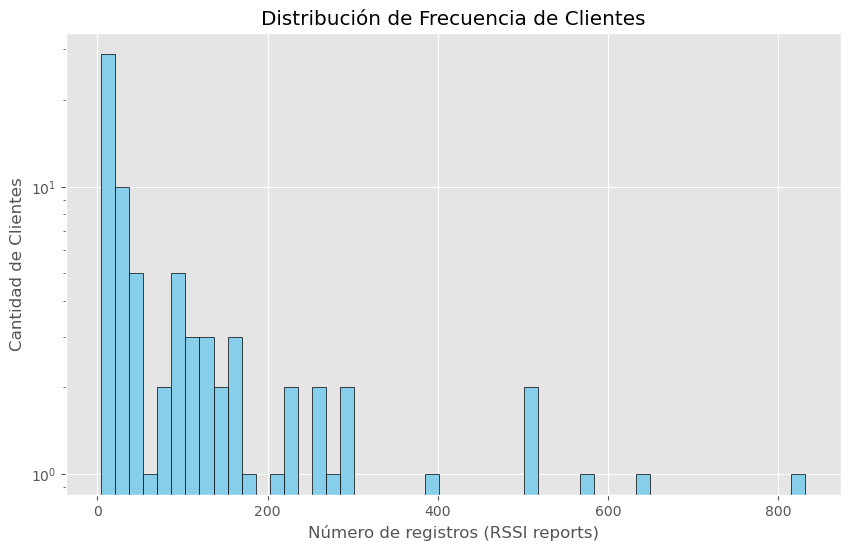

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(freqs, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribución de Frecuencia de Clientes')
plt.xlabel('Número de registros (RSSI reports)')
plt.ylabel('Cantidad de Clientes')
plt.yscale('log') # Escala logarítmica suele ser mejor para estos datos
plt.show()

## 4. Filtrado de Clientes
Basado en el gráfico anterior, elige un `THRESHOLD`. Los clientes con más o igual cantidad de registros serán considerados frecuentes.

In [19]:
THRESHOLD = 20 # Cambia este valor según tu criterio

frequent, sporadic = ca.categorize_clients(freqs, THRESHOLD)

print(f"Umbral seleccionado: {THRESHOLD}")
print(f"Clientes Frecuentes: {len(frequent)}")
print(f"Clientes Esporádicos: {len(sporadic)}")

# Filtrar el DataFrame original para quedarnos con los frecuentes
df_frequent = ca.filter_by_clients(df, frequent)
print(f"\nRegistros originales: {len(df)}")
print(f"Registros de clientes frecuentes: {len(df_frequent)}")

Umbral seleccionado: 20
Clientes Frecuentes: 61
Clientes Esporádicos: 17

Registros originales: 8828
Registros de clientes frecuentes: 8640


## 5. Ejemplo de Datos Filtrados
Mostramos los primeros registros de los clientes frecuentes.

In [20]:
df_frequent.head()

,mac_cliente,mac_ap,banda,antena,rssi
0,8.212.12.130.83.142,0.66.104.213.240.0,0,0,-59
1,8.212.12.130.83.142,0.66.104.213.240.0,0,1,-56
2,8.212.12.130.83.142,0.66.104.213.240.0,1,0,-80
3,8.212.12.130.83.142,0.66.104.213.240.0,1,1,-78
4,8.212.12.130.83.142,44.208.45.106.167.16,0,0,-94
